In [1]:
import pandas as pd
import sqlite3

/var/folders/py/4rt338cj1ks4z3332m7l3f880000gp/T/ipykernel_45794/2059591896.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Compte rendu

In [22]:
data_list = [
    ['rf_produitrecu', 0.9852, 0.6395, 0.7594, 0.9855, 0.644, 0.7628 ],
    ['rf_produitrecu_tps_retard_liv', 0.9314, 0.6613, 0.7606, 0.9104, 0.6426, 0.7474 ],
    ['rf_produitrecu_tps_liv', 0.9369, 0.6478, 0.7545, 0.9372, 0.6528, 0.7582 ],
]

# Define column names
columns = ['Name', 'Train_recall', 'Train_acc','Train_f1','Test_recall','Test_acc','Test_f1']

# Create an empty DataFrame with columns
results = pd.DataFrame(columns=columns)

# Iterate through the list and append rows to the DataFrame
for i, row_data in enumerate(data_list):
    results.loc[i] = row_data


# Display the resulting DataFrame
print(results)

                            Name  Train_recall  Train_acc  Train_f1  \
0                 rf_produitrecu        0.9852     0.6395    0.7594   
1  rf_produitrecu_tps_retard_liv        0.9314     0.6613    0.7606   
2         rf_produitrecu_tps_liv        0.9369     0.6478    0.7545   

   Test_recall  Test_acc  Test_f1  
0       0.9855    0.6440   0.7628  
1       0.9104    0.6426   0.7474  
2       0.9372    0.6528   0.7582  


# Mise en place

In [3]:
connection = sqlite3.connect("olist.db")

df = pd.read_sql_query("SELECT * FROM TrainingDataset",connection)

connection.close()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98344 entries, 0 to 98343
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   review_id                      98344 non-null  object 
 1   order_id                       98344 non-null  object 
 2   review_score                   98344 non-null  int64  
 3   review_comment_title           98344 non-null  object 
 4   review_comment_message         98344 non-null  object 
 5   review_creation_date           98344 non-null  object 
 6   review_answer_timestamp        98344 non-null  object 
 7   customer_id                    98344 non-null  object 
 8   order_status                   98344 non-null  object 
 9   order_purchase_timestamp       98344 non-null  object 
 10  order_approved_at              98344 non-null  object 
 11  order_delivered_carrier_date   98344 non-null  object 
 12  order_delivered_customer_date  95542 non-null 

# premiere RandomForest

In [5]:
from sklearn.model_selection import train_test_split
y = df['score']
X = df[["produit_recu"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [6]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

In [7]:
model.fit(X_train,y_train)

RandomForestClassifier()

In [8]:
from sklearn.metrics import recall_score, accuracy_score, f1_score

recall_train = round(recall_score(y_train, model.predict(X_train)),4)
acc_train = round(accuracy_score(y_train, model.predict(X_train)),4)
f1_train = round(f1_score(y_train, model.predict(X_train)),4)

print(f"Pour le jeu d'entrainement: \n le recall est de {recall_train}, \n l'accuracy de {acc_train} \n le f1 score de {f1_train}")

recall_test = round(recall_score(y_test, model.predict(X_test)),4)
acc_test = round(accuracy_score(y_test, model.predict(X_test)),4)
f1_test = round(f1_score(y_test, model.predict(X_test)),4)

print(f"Pour le jeu de test: \n le recall est de {recall_test}, \n l'accuracy de {acc_test} \n le f1 score de {f1_test}")

model_name = 'rf_produitrecu'
print(f"['{model_name}', {recall_train}, {acc_train}, {f1_train}, {recall_test}, {acc_test}, {f1_test} ],")

Pour le jeu d'entrainement: 
 le recall est de 0.9852, 
 l'accuracy de 0.6395 
 le f1 score de 0.7594
Pour le jeu de test: 
 le recall est de 0.9855, 
 l'accuracy de 0.644 
 le f1 score de 0.7628
['rf_produitrecu', 0.9852, 0.6395, 0.7594, 0.9855, 0.644, 0.7628 ],


# Model avec les délais de livraison

In [16]:
from sklearn.model_selection import train_test_split
y = df['score']
X = df[["produit_recu","temps_livraison"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [17]:
from sklearn.impute import SimpleImputer

# Je choisis la stratgéie de remplacer par le maximu
imputer_temps_livraison = SimpleImputer(strategy="constant",fill_value=X_train.temps_livraison.max())

# j'ajuste mon transformeur pour qu'il prenne la valeur du max sur le jeu de train
imputer_temps_livraison.fit(X_train[["temps_livraison"]])

# je remplace les valeurs manquantes du jeu de train par le max calculé (sur le jeu de train)
X_train[["temps_livraison"]] = imputer_temps_livraison.transform(X_train[["temps_livraison"]])

# je remplace les valeurs manquantes du jeu de test par le max calculé (sur le jeu de train)
X_test[["temps_livraison"]] = imputer_temps_livraison.transform(X_test[["temps_livraison"]])

In [19]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

In [20]:
model.fit(X_train,y_train)

RandomForestClassifier()

In [21]:
from sklearn.metrics import recall_score, accuracy_score, f1_score

recall_train = round(recall_score(y_train, model.predict(X_train)),4)
acc_train = round(accuracy_score(y_train, model.predict(X_train)),4)
f1_train = round(f1_score(y_train, model.predict(X_train)),4)

print(f"Pour le jeu d'entrainement: \n le recall est de {recall_train}, \n l'accuracy de {acc_train} \n le f1 score de {f1_train}")

recall_test = round(recall_score(y_test, model.predict(X_test)),4)
acc_test = round(accuracy_score(y_test, model.predict(X_test)),4)
f1_test = round(f1_score(y_test, model.predict(X_test)),4)

print(f"Pour le jeu de test: \n le recall est de {recall_test}, \n l'accuracy de {acc_test} \n le f1 score de {f1_test}")

model_name = 'rf_produitrecu_tps_retard_liv'
print(f"['{model_name}', {recall_train}, {acc_train}, {f1_train}, {recall_test}, {acc_test}, {f1_test} ],")

Pour le jeu d'entrainement: 
 le recall est de 0.9369, 
 l'accuracy de 0.6478 
 le f1 score de 0.7545
Pour le jeu de test: 
 le recall est de 0.9372, 
 l'accuracy de 0.6528 
 le f1 score de 0.7582
['rf_produitrecu_tps_retard_liv', 0.9369, 0.6478, 0.7545, 0.9372, 0.6528, 0.7582 ],


# Model avec order status

In [44]:
df.columns

Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'customer_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'price', 'freight_value',
       'product_photos_qty', 'product_description_lenght', 'score',
       'temps_livraison', 'retard_livraison', 'produit_recu'],
      dtype='object')

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
y = df['score']
X = df[["produit_recu","temps_livraison","order_status","product_photos_qty","product_description_lenght","retard_livraison",'price', 'freight_value']]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [114]:
############### IV.d Combinaison ##############
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy="constant",fill_value=0), ['temps_livraison',"product_photos_qty","product_description_lenght","retard_livraison",'price', 'freight_value']),
        ('cat', OneHotEncoder(), ['order_status'])
    ],
    remainder="passthrough" 
)

############### IV.d Estimator ##############
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(min_samples_leaf=450,max_depth=3,n_estimators=160)


############### IV.d Final_pipe ##############

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression
pipe = Pipeline([
     ('preprocessor', preprocessor),
     ('robust', RobustScaler()),
     ('poly', PolynomialFeatures(2)),
     ('select_feature',SelectKBest(f_classif, k=10 )),
     ('random_forest', model),
     
])


In [ ]:
pipe.fit(X_train,y_train)

/Users/charles/Documents/pythonProject/date_engineer_week_brief-1/env/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  0  79  80  81  82  91  92  93  96  97 100] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/charles/Documents/pythonProject/date_engineer_week_brief-1/env/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  ['temps_livraison',
                                                   'product_photos_qty',
                                                   'product_description_lenght',
                                                   'retard_livraison', 'price',
                                                   'freight_value']),
                                                 ('cat', OneHotEncoder(),
                                                  ['order_status'])])),
                ('robust', RobustScaler()), ('poly', PolynomialFeatures()),
                ('select_feature', SelectKBest()),
                ('random_forest',
                 RandomForestClassifier(max_depth=3, min_samples_leaf=450,
                                        n_estimators=160))])

In [ ]:
from sklearn.metrics import recall_score, accuracy_score, f1_score

recall_train = round(recall_score(y_train, pipe.predict(X_train)),4)
acc_train = round(accuracy_score(y_train, pipe.predict(X_train)),4)
f1_train = round(f1_score(y_train, pipe.predict(X_train)),4)

print(f"Pour le jeu d'entrainement: \n le recall est de {recall_train}, \n l'accuracy de {acc_train} \n le f1 score de {f1_train}")

recall_test = round(recall_score(y_test, pipe.predict(X_test)),4)
acc_test = round(accuracy_score(y_test, pipe.predict(X_test)),4)
f1_test = round(f1_score(y_test, pipe.predict(X_test)),4)

print(f"Pour le jeu de test: \n le recall est de {recall_test}, \n l'accuracy de {acc_test} \n le f1 score de {f1_test}")

model_name = 'rf_produitrecu_tps_retard_liv'
print(f"['{model_name}', {recall_train}, {acc_train}, {f1_train}, {recall_test}, {acc_test}, {f1_test} ],")

Pour le jeu d'entrainement: 
 le recall est de 0.9788, 
 l'accuracy de 0.643 
 le f1 score de 0.76
Pour le jeu de test: 
 le recall est de 0.9792, 
 l'accuracy de 0.6466 
 le f1 score de 0.763
['rf_produitrecu_tps_retard_liv', 0.9788, 0.643, 0.76, 0.9792, 0.6466, 0.763 ],


In [90]:
from sklearn.model_selection import KFold

# define evaluation
cv = KFold(n_splits=5)

############### V.c Hyparameters space setting ##############

import numpy as np

# define search space
space = dict()
space['random_forest__n_estimators'] = [50,75,100,125,150]
space['random_forest__max_depth'] = [2,3,4]


############### V.d RandomSearch and GridSearc ##############


from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(pipe, space, scoring='f1', cv=cv,verbose=1)


In [91]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         SimpleImputer(fill_value=0,
                                                                                       strategy='constant'),
                                                                         ['temps_livraison',
                                                                          'product_photos_qty',
                                                                          'product_description_lenght',
                                                                          'retard_livraison',
                                                                          'price',
                                                                          'freight_value']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['order_status'])])),
                                       ('random_forest',
                                        RandomForestClassifier(min_samples_leaf=450))]),
             param_grid={'random_forest__max_depth': [2, 3, 4],
                         'random_forest__n_estimators': [50, 75, 100, 125,
                                                         150]},
             scoring='f1', verbose=1)

In [93]:
grid.best_params_

{'random_forest__max_depth': 3, 'random_forest__n_estimators': 150}

In [92]:
from sklearn.metrics import recall_score, accuracy_score, f1_score

recall_train = round(recall_score(y_train, grid.predict(X_train)),4)
acc_train = round(accuracy_score(y_train, grid.predict(X_train)),4)
f1_train = round(f1_score(y_train, grid.predict(X_train)),4)

print(f"Pour le jeu d'entrainement: \n le recall est de {recall_train}, \n l'accuracy de {acc_train} \n le f1 score de {f1_train}")

recall_test = round(recall_score(y_test, grid.predict(X_test)),4)
acc_test = round(accuracy_score(y_test, grid.predict(X_test)),4)
f1_test = round(f1_score(y_test, grid.predict(X_test)),4)

print(f"Pour le jeu de test: \n le recall est de {recall_test}, \n l'accuracy de {acc_test} \n le f1 score de {f1_test}")

model_name = 'rf_produitrecu_tps_retard_liv'
print(f"['{model_name}', {recall_train}, {acc_train}, {f1_train}, {recall_test}, {acc_test}, {f1_test} ],")

Pour le jeu d'entrainement: 
 le recall est de 0.9698, 
 l'accuracy de 0.645 
 le f1 score de 0.7594
Pour le jeu de test: 
 le recall est de 0.9687, 
 l'accuracy de 0.6477 
 le f1 score de 0.7616
['rf_produitrecu_tps_retard_liv', 0.9698, 0.645, 0.7594, 0.9687, 0.6477, 0.7616 ],


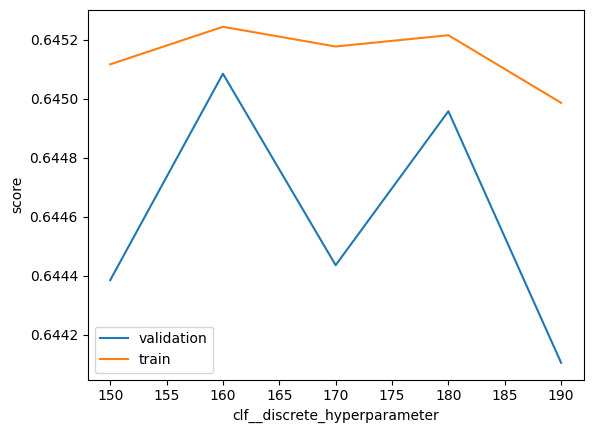

In [102]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt

k = np.arange(150, 200,10)

train_score, val_score = validation_curve(pipe, X_train, y_train,param_name='random_forest__n_estimators',param_range= k, cv=5)

plt.plot(k, val_score.mean(axis=1), label='validation')
plt.plot(k, train_score.mean(axis=1), label='train')

plt.ylabel('score')
plt.xlabel('clf__discrete_hyperparameter')
plt.legend()


In [103]:
val_score

array([[0.64645694, 0.6418176 , 0.64200826, 0.64455037, 0.64709247],
       [0.64766444, 0.64099142, 0.64264379, 0.64480458, 0.64931681],
       [0.64645694, 0.64022879, 0.642898  , 0.64448681, 0.64810931],
       [0.64658405, 0.64143629, 0.64270734, 0.64524944, 0.64880839],
       [0.64645694, 0.64003813, 0.64137274, 0.64505879, 0.64760089]])

- min 10 individu par feuille : 75.52
- min 100 individu par feuille : 0.7595
- min 400 : 0.7596
- min 450:  0.7599
- min 500 indivdus par feuille: 0.7599
- min 600 0.7585
- min 1000 individus par feuille: 0.7582
